In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
% matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
subj = torch.rand(160,768).numpy()
medhx = torch.rand(160,768).numpy()
cont = torch.rand(160,10).numpy()

In [5]:
labels = torch.randint(0,3,(160,)).numpy()

In [6]:
subj.shape, medhx.shape, cont.shape, labels.shape

((160, 768), (160, 768), (160, 10), (160,))

In [7]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [8]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [10]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [38]:
#hyperparameters
lr = 1
epochs = 10
loss_func = nn.CrossEntropyLoss()

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_combined = nn.Linear(30, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        combined = torch.cat((nlp1,nlp2,cont), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [36]:
net = Net()
net

Net(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_combined): Linear(in_features=30, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)

### testing the forward method

In [33]:
x1,x2,x3,x4 = next(iter(trainloader))

In [34]:
net(x1,x2,x3)

tensor([[-0.2226,  0.1290,  0.1714, -0.1460],
        [-0.1716,  0.1199,  0.1439, -0.2022],
        [-0.1964,  0.1718,  0.1426, -0.1359],
        [-0.2518,  0.0691,  0.1552, -0.1029]], grad_fn=<AddmmBackward>)

### trying the training loop

In [39]:
def train_model(model):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx)#, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            if step_num %12 == 0:
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [40]:
cum_loss = train_model(net)

Epoch:  1
0/36.0 loss: 1.0526337623596191 
Epoch:  1
12/36.0 loss: 41.83641877999673 
Epoch:  1
24/36.0 loss: 22.575640099048613 
Epoch:  2
0/36.0 loss: 1.0975940227508545 
Epoch:  2
12/36.0 loss: 1.2829447663747346 
Epoch:  2
24/36.0 loss: 1.3403034138679504 
Epoch:  3
0/36.0 loss: 1.0640887022018433 
Epoch:  3
12/36.0 loss: 1.2593571910491357 
Epoch:  3
24/36.0 loss: 1.2724158573150635 
Epoch:  4
0/36.0 loss: 1.0711201429367065 
Epoch:  4
12/36.0 loss: 1.2784013610619764 
Epoch:  4
24/36.0 loss: 1.2847436308860778 
Epoch:  5
0/36.0 loss: 1.072556495666504 
Epoch:  5
12/36.0 loss: 1.2776251710378206 
Epoch:  5
24/36.0 loss: 1.283041579723358 
Epoch:  6
0/36.0 loss: 1.0720102787017822 
Epoch:  6
12/36.0 loss: 1.276703880383418 
Epoch:  6
24/36.0 loss: 1.282629632949829 
Epoch:  7
0/36.0 loss: 1.07192862033844 
Epoch:  7
12/36.0 loss: 1.2761239959643438 
Epoch:  7
24/36.0 loss: 1.2822259831428529 
Epoch:  8
0/36.0 loss: 1.0718587636947632 
Epoch:  8
12/36.0 loss: 1.2757156766377962 
Epo

In [41]:
cum_loss

[580.8011103272438,
 47.519757986068726,
 45.66475993394852,
 46.122944831848145,
 46.101360857486725,
 46.10654467344284,
 46.104398012161255,
 46.10389906167984,
 46.103628158569336,
 46.1034300327301]

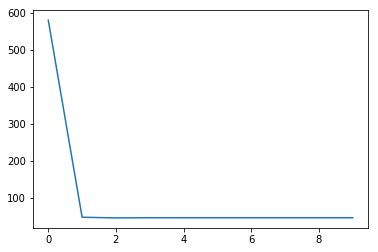

In [42]:
plt.plot(cum_loss)

## now we are going to make the model more complex and add embedding

In [44]:
cats = np.random.randint(1, 30, size=(160))

In [45]:
len(set(cats))

29

In [46]:
embedding_size = min(50, len(set(cats))+1// 2);
embedding_size

29

In [50]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [51]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [53]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [47]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.embedding = nn.Embedding(len(set(cats))+1, embedding_size + 1)
        self.linear_cat = nn.Linear(30,10)
        self.linear_combined = nn.Linear(40, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont,cat_var):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        embeds = self.embedding(cat_var)
        cats = F.relu(self.linear_cat(embeds))
        combined = torch.cat((nlp1,nlp2,cont,cats), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [48]:
def train_model2(model):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            if step_num %12 == 0:
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [49]:
net = Net1()
print(net)

Net1(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (embedding): Embedding(30, 30)
  (linear_cat): Linear(in_features=30, out_features=10, bias=True)
  (linear_combined): Linear(in_features=40, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)


In [54]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [55]:
net(x1,x2,x3,x4)

tensor([[ 0.0868,  0.2228,  0.2944, -0.3075],
        [ 0.1226,  0.1630,  0.3105, -0.2854],
        [ 0.1171,  0.2344,  0.3092, -0.2632],
        [ 0.0056,  0.2224,  0.2286, -0.2938]], grad_fn=<AddmmBackward>)

In [56]:
cum_loss = train_model2(net)

Epoch:  1
0/36.0 loss: 1.3173404932022095 
Epoch:  1
12/36.0 loss: 478.08799888995975 
Epoch:  1
24/36.0 loss: 249.2812801194191 
Epoch:  2
0/36.0 loss: 1.1423039436340332 
Epoch:  2
12/36.0 loss: 1.3834199492747967 
Epoch:  2
24/36.0 loss: 1.3714889669418335 
Epoch:  3
0/36.0 loss: 1.0904712677001953 
Epoch:  3
12/36.0 loss: 1.2680792395885174 
Epoch:  3
24/36.0 loss: 1.269689657688141 
Epoch:  4
0/36.0 loss: 1.0702341794967651 
Epoch:  4
12/36.0 loss: 1.2725507708696218 
Epoch:  4
24/36.0 loss: 1.281328055858612 
Epoch:  5
0/36.0 loss: 1.0719343423843384 
Epoch:  5
12/36.0 loss: 1.2722261456342845 
Epoch:  5
24/36.0 loss: 1.2796733736991883 
Epoch:  6
0/36.0 loss: 1.0713878870010376 
Epoch:  6
12/36.0 loss: 1.2723769316306481 
Epoch:  6
24/36.0 loss: 1.2800783824920654 
Epoch:  7
0/36.0 loss: 1.0713046789169312 
Epoch:  7
12/36.0 loss: 1.2725464426554167 
Epoch:  7
24/36.0 loss: 1.2801926112174988 
Epoch:  8
0/36.0 loss: 1.071189045906067 
Epoch:  8
12/36.0 loss: 1.2726234518564665 


#### now I'm going to go through the process of creating a category variable and turing it into embedded classes

In [74]:
animals = ['manatee', 'dog', 'giraffe', 'narwhal', 'cat', 'elephant', 'mouse', 'dingo', 'wombat', 'skunk']
cat_data = [[animal]* 16 for animal in animals]
cat_data = [item for sublist in cat_data for item in sublist]
random.shuffle(cat_data)

In [75]:
animal_to_num = {animal:i for i,animal in enumerate(list(set(cat_data)))}
num_to_animal = {i:animal for animal, i in enumerate(list(set(cat_data)))}

In [76]:
numerical_cat_data = [animal_to_num[item] for item in cat_data]

In [77]:
len(numerical_cat_data)

160

In [78]:
set(numerical_cat_data)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}